In [3]:
import cv2
import sys
print(sys.executable)

d:\dl_projects\dl\genlib\.venv\Scripts\python.exe


Etched layer depth (pixels): 178


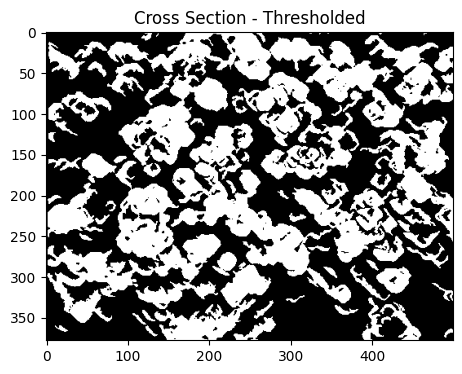

In [12]:
# Example cross_section.py
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, measure, morphology

# Load cross-section image
cross_section_path = 'image1.png'
cross_img_gray = io.imread(cross_section_path, as_gray=True)

# Threshold to isolate etched layer
th_val = filters.threshold_otsu(cross_img_gray)
binary_cs = cross_img_gray > th_val

# Optionally clean up
binary_cs = morphology.remove_small_objects(binary_cs, 50)

# You can measure the thickness by scanning vertically or using regionprops
# For instance, label the etched region:
labeled_cs = measure.label(binary_cs)
props_cs = measure.regionprops(labeled_cs)

# If there's only one main etched band, you might do:
if len(props_cs) > 0:
    # Find the bounding box of the largest region
    largest_region = max(props_cs, key=lambda x: x.area)
    minr, minc, maxr, maxc = largest_region.bbox
    
    # 'Depth' could be approximated by (maxr - minr) in pixel units
    depth_pixels = maxr - minr
    print("Etched layer depth (pixels):", depth_pixels)
    
    # Convert to micrometers if you know your scale, e.g. 1 pixel = 0.1 µm
    # depth_um = depth_pixels * 0.1
    # print("Etched layer depth (µm):", depth_um)

# Visualize
plt.figure(figsize=(6,4))
plt.imshow(binary_cs, cmap='gray')
plt.title('Cross Section - Thresholded')
plt.show()

Number of detected pits: 51
Mean pit area (pixels): 1673.9607843137255
Mean pit equivalent diameter (pixels): 30.126877250242355


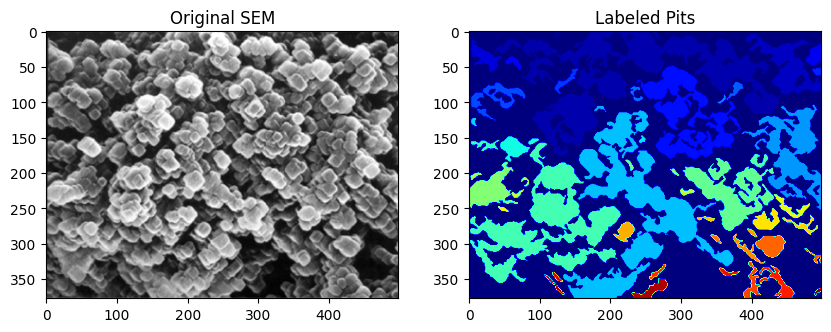

H0 intervals:
 [[0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 ...
 [6.40312424 7.07106781]
 [4.47213595 7.21110255]
 [0.                inf]]
H1 intervals:
 [[ 0.          1.        ]
 [ 0.          1.        ]
 [ 0.          1.        ]
 ...
 [ 0.         23.19482701]
 [ 0.         24.18677324]
 [ 0.         25.17935662]]
Mean finite H0 persistence: 1.4069723574545623
Mean finite H1 persistence: 3.54207274076606


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, measure, morphology
from scipy.ndimage import distance_transform_edt
import gudhi

# ---------------------------
# 1. Load and Preprocess Image
# ---------------------------
# Replace 'pits_image.png' with the actual file name of your SEM pit image
image_path = 'image1.png'
image_gray = io.imread(image_path, as_gray=True)

# Optional: apply a slight Gaussian blur to reduce noise
image_blur = cv2.GaussianBlur((image_gray * 255).astype(np.uint8), (3,3), 0)
image_blur = image_blur.astype(float) / 255.0  # revert to float [0..1]

# ---------------------------
# 2. Threshold and Segment
# ---------------------------
# Example: use Otsu thresholding
thresh_val = filters.threshold_otsu(image_blur)
binary = image_blur > thresh_val

# Optional: remove small spurious spots and fill small holes
binary = morphology.remove_small_objects(binary, min_size=50)
binary = morphology.remove_small_holes(binary, area_threshold=50)

# ---------------------------
# 3. Label and Measure Pits
# ---------------------------
labeled = measure.label(binary)
props = measure.regionprops(labeled)

# Extract measurements of interest
areas = [prop.area for prop in props]
equiv_diameters = [prop.equivalent_diameter for prop in props]
perimeters = [prop.perimeter for prop in props]

print("Number of detected pits:", len(props))
print("Mean pit area (pixels):", np.mean(areas))
print("Mean pit equivalent diameter (pixels):", np.mean(equiv_diameters))

# (If you know the SEM scale, e.g., X micrometers per pixel, multiply to get real units)

# ---------------------------
# 4. Visualize Segmentation
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_gray, cmap='gray')
axes[0].set_title('Original SEM')
axes[1].imshow(labeled, cmap='jet')
axes[1].set_title('Labeled Pits')
plt.show()

# ---------------------------
# 5. (Optional) Persistent Homology
# ---------------------------
# Approach: compute the distance transform of the binary image,
# then build a cubical complex in GUDHI and get persistence diagrams.

dist_transform = distance_transform_edt(binary)

# GUDHI expects a flattened 2D array for CubicalComplex
flat_dist = dist_transform.flatten(order='C')
height, width = dist_transform.shape

# Create a CubicalComplex in 2D
cubical_complex = gudhi.CubicalComplex(
    dimensions = [height, width],
    top_dimensional_cells = flat_dist
)

cubical_complex.compute_persistence()

# Extract the persistence intervals for H0 (connected components) and H1 (loops)
diag = cubical_complex.persistence_intervals_in_dimension(0)
diag_h1 = cubical_complex.persistence_intervals_in_dimension(1)

print("H0 intervals:\n", diag)
print("H1 intervals:\n", diag_h1)

# Typically, you look at the lengths of these intervals (d - b)
# to interpret feature size or loop size. 
# For example, you could compute the average "persistence" in H0:

pers_h0 = [interval[1] - interval[0] for interval in diag if interval[1] < float('inf')]
mean_persistence_h0 = np.mean(pers_h0) if len(pers_h0) > 0 else 0
print("Mean finite H0 persistence:", mean_persistence_h0)

# Similarly for H1, to see if you have ring-like structures
pers_h1 = [interval[1] - interval[0] for interval in diag_h1 if interval[1] < float('inf')]
mean_persistence_h1 = np.mean(pers_h1) if len(pers_h1) > 0 else 0
print("Mean finite H1 persistence:", mean_persistence_h1)


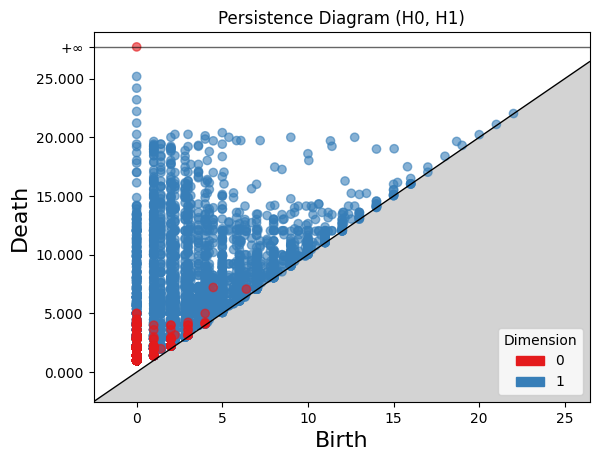

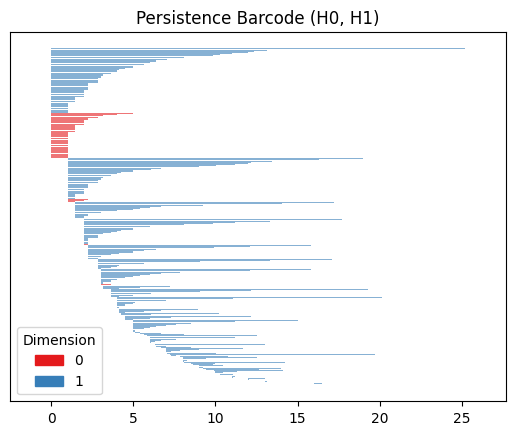

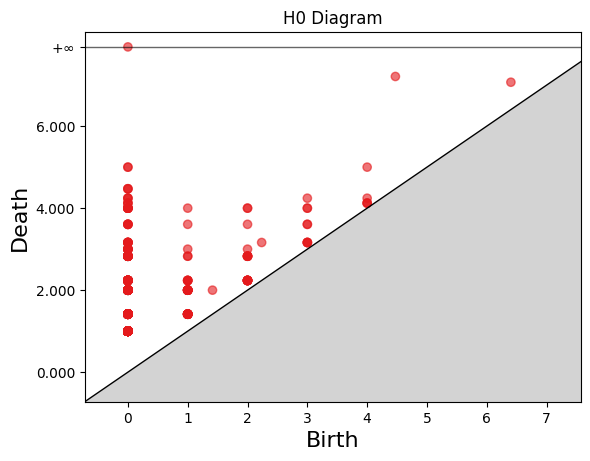

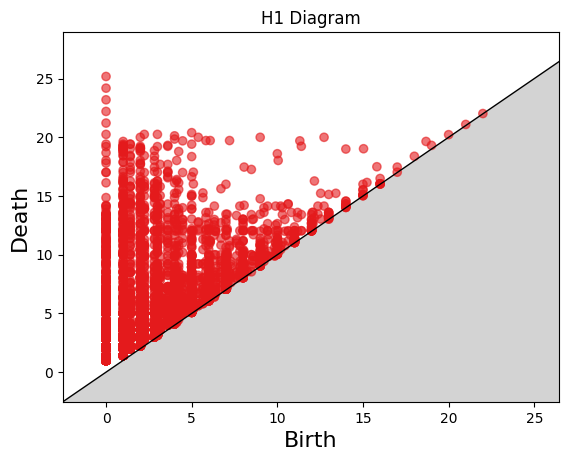

In [16]:
import gudhi

# Suppose your CubicalComplex is named 'cubical_complex'
# and you've already done:
# cubical_complex.compute_persistence()

# Retrieve full persistence (both H0, H1, etc.)
diag_full = cubical_complex.persistence()

# -- Plot the persistence diagram --
gudhi.plot_persistence_diagram(diag_full)
plt.title("Persistence Diagram (H0, H1)")
plt.show()

# -- Plot the persistence barcode --
gudhi.plot_persistence_barcode(diag_full)
plt.title("Persistence Barcode (H0, H1)")
plt.show()

# If you want to isolate only H0 or H1 intervals:
diag_h0 = cubical_complex.persistence_intervals_in_dimension(0)
diag_h1 = cubical_complex.persistence_intervals_in_dimension(1)

# You could plot them separately if desired
gudhi.plot_persistence_diagram(diag_h0)
plt.title("H0 Diagram")
plt.show()

gudhi.plot_persistence_diagram(diag_h1)
plt.title("H1 Diagram")
plt.show()

